# IR generation using FIR Method

In this technique, fir filter kernels are precomputed in the frequency domain by windowing ideal octave band filters and their time domain versions are stored into a file. The individual kernels are weighted and summed together to make up the frequency contents of a given ray. The room impulse response is then constructed by delaying and summing individual weigthed sums of the generated filter kernels. The below diagram shows the process of putting together a room impulse response.

<img src="./fir_method.png" alt="Drawing" style="width: 900px;"/>

The python script below generates the time domain filter kernels for octave band frequencies between 125 Hz and 16000 Hz.

In [1]:
import numpy as np
import scipy.signal as sig
import matplotlib.pyplot as plt
import json
from scipy.io.wavfile import write as wavwrite

In [2]:
matFilepath = "../../res/materials.json"
matFile = open(matFilepath)
matData = json.load(matFile)

freqBands = np.array(matData["Bands"])

fs = 48000
bandEdges = np.insert(np.sqrt(freqBands[:-1]*freqBands[1:]), [0, len(freqBands)-1], [0, fs/2])
N = 2**np.ceil(np.log2(fs / bandEdges[1])).astype(int)

In [3]:
bandEdges_N = (bandEdges * N / fs).astype(int)
H = np.zeros((N//2 , len(freqBands)))
for i in range(0, len(bandEdges_N)-1):
    H[bandEdges_N[i]:bandEdges_N[i+1], i] = 1
H = np.append(H, [H[-1,:]], axis=0) # add magnitudes at fs/2

In [4]:
h = np.fft.irfft(H, n=N, axis=0)
h = np.roll(h, N//2, axis=0)
win = sig.hann(N)
hwin = h * np.reshape(win, (N, 1))

wavwrite("../../res/irKernels.wav", fs, hwin)

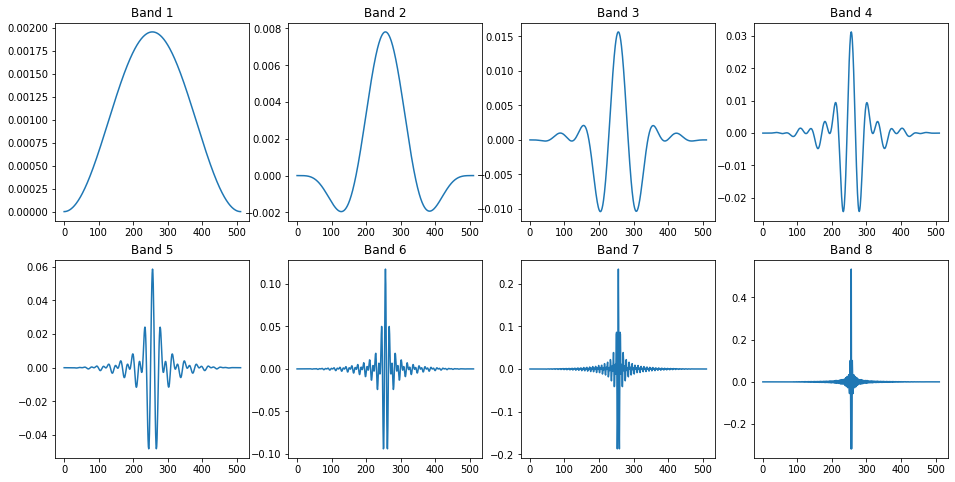

In [11]:
plt.figure(figsize=(16, 8))
for i in range(0, len(freqBands)):
    plt.subplot(2, len(freqBands)//2, i+1)
    plt.plot(hwin[:,i])
    plt.title(f"Band {i+1}")

Text(0, 0.5, 'Magnitude (dB)')

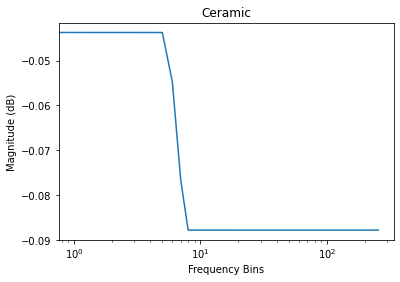

In [6]:
woodImp = np.dot(hwin, np.sqrt(1 - np.array(matData["Materials"][4]["Absorption"])))
woodFR = np.fft.fft(woodImp, n=N)
plt.plot(20*np.log10(woodFR[:N//2]))
plt.xscale('log')
plt.title(f"{matData['Materials'][4]['Name']}")
plt.xlabel("Frequency Bins")
plt.ylabel("Magnitude (dB)")